In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
%%capture
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

**Continue training on description generation**

In [ ]:
from transformers import Blip2ForConditionalGeneration, AutoProcessor
from peft import PeftModel, PeftConfig

peft_model_id = "SeeonQwQ/blip2_frame_v4.0"
config = PeftConfig.from_pretrained(peft_model_id)
model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id, is_trainable=True)
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

KeyboardInterrupt: 

Helper Methods

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

def calculate_covered_patch_indices(batch_bbox_coords, original_image_size, target_image_size=(224, 224), patch_size=(14, 14)):
    """
    Calculate the patch indices for the area covered by the bounding boxes for a batch of images.

    Parameters:
    - batch_bbox_coords: List of bounding box coordinates for each image,
                         where each bounding box is [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    - original_image_size: Original size of the image (width, height)
    - target_image_size: Target size of the image after resizing (width, height)
    - patch_size: Size of each patch (width, height)

    Returns:
    - List of sets, each set containing indices representing patches within the bounding box for each image.
    """
    batch_patch_indices = []
    for bbox_coords in batch_bbox_coords:
        # Calculate scale factors
        scale_w = target_image_size[0] / original_image_size[0]
        scale_h = target_image_size[1] / original_image_size[1]

        # Scale bbox coordinates to the resized image
        scaled_bbox_coords = [(int(x * scale_w), int(y * scale_h)) for x, y in bbox_coords]

        # Get min and max coordinates to define the bounding box
        x_coords, y_coords = zip(*scaled_bbox_coords)
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        # Calculate the patch indices covered by the bbox
        x_min_patch = x_min // patch_size[0]
        x_max_patch = x_max // patch_size[0]
        y_min_patch = y_min // patch_size[1]
        y_max_patch = y_max // patch_size[1]

        covered_patch_indices = set()
        for x_patch in range(x_min_patch, x_max_patch + 1):
            for y_patch in range(y_min_patch, y_max_patch + 1):
                patch_index = y_patch * (target_image_size[0] // patch_size[0]) + x_patch
                covered_patch_indices.add(patch_index)
        batch_patch_indices.append(covered_patch_indices)

    return batch_patch_indices

In [ ]:
import torch

def bbox_to_corners(bbox, image_width, image_height, device=None):
    """
    Converts a bounding box from (xmin, ymin, xmax, ymax) to a tensor of shape (N, 4, 2) containing
    coordinates for each corner of the bounding boxes in the batch.

    Args:
        bbox (torch.Tensor): Normalized bounding box tensor of shape (N, 4) containing [xmin, ymin, xmax, ymax].
        image_width (int): Original width of the image.
        image_height (int): Original height of the image.
        device (torch.device): Device to perform the computation on.

    Returns:
        torch.Tensor: Tensor of shape (N, 4, 2) where each entry is [x, y] coordinates of the corners.
    """
    if device is not None:
        bbox = bbox.to(device)

    # Convert normalized bounding box coordinates to pixel values
    scale_tensor = torch.tensor([image_width, image_height, image_width, image_height], dtype=torch.float32, device=device)
    box = bbox * scale_tensor

    xmin, ymin, xmax, ymax = box.int().unbind(dim=1)

    # Create tensor for corners in the format [x, y]
    corners = torch.stack([
        torch.stack([xmin, ymin], dim=1),  # Top-left
        torch.stack([xmax, ymin], dim=1),  # Top-right
        torch.stack([xmax, ymax], dim=1),  # Bottom-right
        torch.stack([xmin, ymax], dim=1)   # Bottom-left
    ], dim=1)

    return corners

# Example Usage
bbox_tensor = torch.tensor([[0.1, 0.1, 0.2, 0.2],
                            [0.2, 0.2, 0.3, 0.3]], dtype=torch.float32)  # Example with 2 bboxes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
corners = bbox_to_corners(bbox_tensor, 2704, 1520, device)
print(corners)

tensor([[[270, 152],
         [540, 152],
         [540, 304],
         [270, 304]],

        [[540, 304],
         [811, 304],
         [811, 456],
         [540, 456]]], device='cuda:0', dtype=torch.int32)


Dataset / Dataloader

In [ ]:
import json
import requests
from PIL import Image, ImageSequence
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torchvision.ops import box_convert
from torch.utils.data import Dataset
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import torch.nn.functional as F
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import ImageList
from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import Boxes
import torch.nn as nn

class RelativePositionEmbedding(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.embedding = nn.Linear(4, embedding_size)

    def forward(self, relative_positions):
        return self.embedding(relative_positions)

class ImageCaptioningDataset(Dataset):
    def __init__(self, json_file, processor):
        with open(json_file, 'r') as f:
            try:
                data = json.load(f)
                print("Loaded JSON data successfully.")
            except json.JSONDecodeError as e:
                print(f"Error loading JSON: {e}")
                raise e
        self.dataset = [item for item in data if item["Simplified_Caption"] != "N/A"]
        self.model, self.roi_pooler, self.device = self.initialize_predictor()
        self.position_embedding = RelativePositionEmbedding(128).to(self.device)
        self.processor = processor
        # self.max_objects = self.get_max_objects_in_dataset()
        self.max_objects = 59

    def __len__(self):
        return len(self.dataset)

    def initialize_predictor(self):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
        cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        model = build_model(cfg)
        model.to(cfg.MODEL.DEVICE)
        DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
        model.eval()

        output_size = (7, 7)
        scales = (0.25, 0.125, 0.0625, 0.03125)
        sampling_ratio = 0
        roi_pooler = ROIPooler(output_size, scales, sampling_ratio, pooler_type="ROIAlign")
        return model, roi_pooler, cfg.MODEL.DEVICE

    def get_max_objects_in_dataset(self):
        max_objects = 0
        for item in tqdm(self.dataset, desc="Calculating max objects"):
            image_url = item["s3_fileUrl"]
            response = requests.get(image_url)
            image = Image.open(BytesIO(response.content))
            image_np = np.array(image)
            image_tensor = torch.tensor(image_np.transpose(2, 0, 1), dtype=torch.float32).to(self.device)
            image_list = ImageList.from_tensors([image_tensor], self.model.backbone.size_divisibility).to(self.device)
            with torch.no_grad():
                backbone_features = self.model.backbone(image_list.tensor)
                proposals, _ = self.model.proposal_generator(image_list, backbone_features)
                predictions, _ = self.model.roi_heads(image_list, backbone_features, proposals)
                final_instances = predictions[0]
                num_objects = len(final_instances.pred_classes)
                max_objects = max(max_objects, num_objects)
        return max_objects

    def get_image_features(self, image_url):
        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content))
        image_np = np.array(image)
        image_tensor = torch.tensor(image_np.transpose(2, 0, 1), dtype=torch.float32).to(self.device)
        image_list = ImageList.from_tensors([image_tensor], self.model.backbone.size_divisibility).to(self.device)
        with torch.no_grad():
            backbone_features = self.model.backbone(image_list.tensor)
            proposals, _ = self.model.proposal_generator(image_list, backbone_features)
            predictions, _ = self.model.roi_heads(image_list, backbone_features, proposals)
            final_instances = predictions[0]
            feature_maps = [backbone_features[f] for f in self.model.roi_heads.in_features]
            boxes_tensor = final_instances.pred_boxes.tensor.to(self.device)
            boxes_list = [Boxes(boxes_tensor)]
            detected_object_features = self.roi_pooler(feature_maps, boxes_list).to(self.device)

        traffic_related_classes = {
            0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle',
            5: 'bus', 6: 'truck', 9: 'traffic light', 12: 'stop sign'
        }

        object_features = []
        bbox = []
        for i, (cls, box) in enumerate(zip(final_instances.pred_classes.cpu().numpy(), boxes_tensor.cpu().numpy())):
            if cls in traffic_related_classes.keys():
                class_idx = list(traffic_related_classes.keys()).index(cls)
                class_label = F.one_hot(torch.tensor([class_idx], device=self.device), num_classes=len(traffic_related_classes) + 1).float().squeeze(0)
                box_normalized = torch.from_numpy(box / np.array([image.width, image.height, image.width, image.height])).to(self.device).float()
                bbox.append(box_normalized)
                relative_embeddings = self.position_embedding(box_normalized)
                object_feature = torch.mean(detected_object_features[i], dim=[1, 2]).flatten()
                feature = torch.cat((class_label, relative_embeddings, object_feature))
                object_features.append(feature)

        global_class_idx = len(traffic_related_classes)
        global_class_label = F.one_hot(torch.tensor([global_class_idx], device=self.device), num_classes=len(traffic_related_classes) + 1).float().squeeze(0)
        global_box_normalized = torch.tensor([0, 0, 1, 1], dtype=torch.float32).to(self.device)
        bbox.append(global_box_normalized)
        global_embeddings = self.position_embedding(global_box_normalized)
        global_feature = torch.mean(backbone_features["p5"], dim=[2, 3]).flatten().to(self.device)
        global_feature_vector = torch.cat((global_class_label, global_embeddings, global_feature))
        object_features.insert(0, global_feature_vector)

        if len(object_features) < self.max_objects + 1:
            padding = torch.zeros(self.max_objects + 1 - len(object_features), object_features[0].shape[0]).to(self.device)
            object_features = torch.cat((torch.stack(object_features), padding), dim=0)
            padding_box = torch.zeros(self.max_objects + 1 - len(bbox), 4).to(self.device)
            bbox_tensor = torch.cat((torch.stack(bbox), padding_box), dim=0)
        else:
            object_features = torch.stack(object_features[:self.max_objects + 1])
            bbox_tensor = torch.stack(bbox[:self.max_objects + 1])

        return object_features, bbox_tensor

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image_url = item["s3_fileUrl"]
        caption = item["Simplified_Caption"]
        action = item["label"]
        object_features, bbox = self.get_image_features(image_url)

        geometry = item["geometry"]
        agent_classifier = item["Agent-classifier"]

        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content))

        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = caption
        encoding["s3_fileUrl"] = image_url
        encoding["agent_classifier"] = agent_classifier
        encoding["geometry"] = geometry
        encoding["action"] = action
        encoding["object_features"] = object_features
        encoding["bbox"] = bbox

        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key == "pixel_values":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        elif key == "geometry" or key == "action" or key == "object_features" or key == "bbox":
            processed_batch[key] = torch.stack([torch.tensor(example[key]) for example in batch])
        elif key == "text":
            text_inputs = processor.tokenizer([example["text"] for example in batch], padding=True, return_tensors="pt")
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
        elif key == "agent_classifier" or key == "s3_fileUrl":
            processed_batch[key] = [example[key] for example in batch]
        else:
            other_inputs = processor.tokenizer([example[key] for example in batch], padding=True, return_tensors="pt")
            processed_batch[key] = other_inputs["input_ids"]
    return processed_batch



In [ ]:
# Example usage
dataset = ImageCaptioningDataset(json_file="./processed_dataset_4.json", processor=processor)
max_objects = dataset.max_objects
print(f"Maximum number of detected objects in the dataset: {max_objects}")

Loaded JSON data successfully.


model_final_f6e8b1.pkl: 243MB [00:01, 142MB/s]                           
Calculating max objects:   0%|          | 0/8712 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Calculating max objects: 100%|██████████| 8712/8712 [1:47:39<00:00,  1.35it/s]

Maximum number of detected objects in the dataset: 59


In [ ]:
from torch.utils.data import random_split
from transformers import Blip2ForConditionalGeneration, AutoProcessor

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

# Define your dataset
dataset = ImageCaptioningDataset("./processed_dataset_4.json", processor)
train_ratio = 0.9

# Calculate the sizes of the training and validation sets based on your desired ratio
total_size = len(dataset)
train_size = int(total_size * train_ratio)
valid_size = total_size - train_size

# Use random_split to split the dataset
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Create data loaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

Loaded JSON data successfully.


model_final_f6e8b1.pkl: 243MB [00:01, 156MB/s]                           


In [ ]:
# Skip this for re-training

from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)


Tarin + Evaluate attention predictor

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ObjectAttentionModel(nn.Module):
    def __init__(self, num_heads, num_layers, dropout_rate, num_action_classes, max_objects):
        super(ObjectAttentionModel, self).__init__()
        self.input_dim = 393  # Total input features per object
        self.project_dim = 512  # Dimension to project the input features to before passing to the transformer
        self.projector = nn.Linear(self.input_dim, self.project_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.project_dim, nhead=num_heads, dropout=dropout_rate, batch_first=True),
            num_layers=num_layers
        )
        self.max_objects = max_objects
        # Action head with multiple layers
        self.action_head = nn.Sequential(
            nn.Linear(self.project_dim, self.project_dim // 2),  # Reduce dimension
            nn.ReLU(),  # Activation function
            nn.Dropout(dropout_rate),  # Dropout to prevent overfitting
            nn.Linear(self.project_dim // 2, self.project_dim // 4),  # Further reduction
            nn.ReLU(),  # Another activation layer
            nn.Linear(self.project_dim // 4, num_action_classes)  # Final layer to output action classes
        )

    def forward(self, object_features, bbox_coordinates):
        # object_features: [batch_size, num_objects, num_classes + 4] (concatenated one-hot classes and bbox features)
        # Ensure that the number of objects does not exceed max_objects
        if object_features.size(1) > self.max_objects + 1:
            object_features = object_features[:, :self.max_objects + 1, :]
            bbox_coordinates = bbox_coordinates[:, :self.max_objects + 1, :]

        object_features = self.projector(object_features)  # [batch_size, num_objects, project_dim]

        # Transformer processing for attention
        transformer_output = self.transformer_encoder(object_features)

        # Calculate attention weights for each object
        attention_scores = transformer_output.mean(dim=-1)
        attention_weights = F.softmax(attention_scores, dim=1)

        # Aggregate context for action prediction
        global_context = (transformer_output * attention_weights.unsqueeze(-1)).sum(dim=1)

        # Predict action
        action_pred = self.action_head(global_context)

        return action_pred, bbox_coordinates, attention_weights

# Example usage
num_heads = 8
num_layers = 6
dropout_rate = 0.1
num_action_classes = 5  # Example number of action classes
max_objects = 59  # Assuming you have determined this value from your dataset

attention_predictor_new = ObjectAttentionModel(num_heads, num_layers, dropout_rate, num_action_classes, max_objects)


In [ ]:
import torch

def normalize_bboxes(bboxes, img_width, img_height):
    """
    Normalize bounding box coordinates to be between 0 and 1.

    Parameters:
    - bboxes (tensor): Tensor of bounding boxes, each specified by four coordinates.
    - img_width (int): Width of the image.
    - img_height (int): Height of the image.

    Returns:
    - Tensor: Normalized bounding boxes of shape (batch_size, 4).
    """
    if isinstance(bboxes, list):
        bboxes = torch.tensor(bboxes)
    elif isinstance(bboxes, np.ndarray):
        bboxes = torch.from_numpy(bboxes)

    # Convert from four corners to (x_min, y_min, x_max, y_max)
    if bboxes.dim() == 3 and bboxes.size(1) == 4:
        x_min = torch.min(bboxes[:, :, 0], dim=1)[0]
        y_min = torch.min(bboxes[:, :, 1], dim=1)[0]
        x_max = torch.max(bboxes[:, :, 0], dim=1)[0]
        y_max = torch.max(bboxes[:, :, 1], dim=1)[0]
    else:
        raise ValueError(f"Unexpected bboxes shape: {bboxes.shape}")

    # Normalize coordinates
    x_min = x_min / img_width
    y_min = y_min / img_height
    x_max = x_max / img_width
    y_max = y_max / img_height

    # Stack to get the final tensor of shape (batch_size, 4)
    normalized_bboxes = torch.stack((x_min, y_min, x_max, y_max), dim=-1)

    return normalized_bboxes


In [ ]:
import torch
from tqdm import tqdm
from transformers import AutoTokenizer
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

# Choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define IoU function
def bbox_iou(box1, box2):
    inter_min_xy = torch.max(box1[:, :2], box2[:, :2])
    inter_max_xy = torch.min(box1[:, 2:], box2[:, 2:])
    inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)

    inter_area = inter[:, 0] * inter[:, 1]
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    union_area = area1 + area2 - inter_area
    union_area = torch.clamp(union_area, min=1e-10)  # Prevent division by zero
    iou = inter_area / union_area
    return iou


attention_predictor_new.to(device)

# Training loop
attention_predictor_new.train()
criterion2 = nn.CrossEntropyLoss()  # For action classification

# Setup the optimizer
optimizer = optim.Adam(attention_predictor_new.parameters(), lr=0.0001)

# Define the scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

for epoch in range(5):
    # Training loop
    attention_predictor_new.train()

    total_loss = 0
    num_batches = 0

    # Initialize the progress bar
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch + 1}/5")

    for idx, batch in progress_bar:
        # Move the batch to the selected device
        object_features = batch["object_features"].to(device, torch.float32)
        batch_bbox_coords = batch["geometry"].to(device, torch.float32)
        bbox = batch["bbox"].to(device, torch.float32)
        actions = batch["action"].to(device)  # Sample target actions [0, 1, 2, 0, ...., 4]

        # Image dimensions, assuming all images are resized to the same dimensions
        img_width, img_height = 2704, 1520  # You might adjust this based on your preprocessing

        target_bboxes = normalize_bboxes(batch_bbox_coords.clone(), img_width, img_height).to(device)

        # Forward pass
        predicted_actions, all_bbox_coords, attention_weights = attention_predictor_new(object_features, bbox)

        # Expand target_bboxes to match the shape of all_bbox_coords for IoU calculation
        expanded_target_bboxes = target_bboxes.unsqueeze(1).expand_as(all_bbox_coords)

        # Calculate IoU for all objects
        ious = bbox_iou(all_bbox_coords.reshape(-1, 4), expanded_target_bboxes.reshape(-1, 4))
        ious = ious.view(batch["object_features"].size(0), -1)

        # Normalize attention weights
        attention_weights = F.softmax(attention_weights, dim=1)

        # Ensure no invalid values in log
        safe_attention_weights = attention_weights + 1e-10
        log_attention_weights = torch.log(safe_attention_weights)

        # Calculate loss based on IoU and attention weights
        attention_loss = -torch.sum(ious * log_attention_weights) / ious.size(0)

        # Compute action classification loss
        action_loss = criterion2(predicted_actions, actions)

        # Combine the losses
        loss = attention_loss + action_loss

        total_loss += loss.item()
        num_batches += 1

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        progress_bar.set_postfix({'loss': total_loss / num_batches})

    # Print average loss for the epoch
    avg_loss = total_loss / num_batches
    scheduler.step()
    print(f"Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")
    torch.save(attention_predictor_new.state_dict(), '/content/drive/MyDrive/attention_predictor_state_dict.pth')


In [ ]:
attention_predictor_new.load_state_dict(torch.load("/content/drive/MyDrive/attention_predictor_state_2_dict.pth"))

<All keys matched successfully>

In [ ]:
import torch
from tqdm import tqdm
from sklearn.cluster import KMeans
import torch.nn.functional as F
import numpy as np

def filter_bboxes_and_scores(bbox_coords, attention_scores):
    # Filter out boxes that are all zeros or represent the whole image
    valid_indices = (bbox_coords.sum(dim=-1) != 0) & ((bbox_coords != torch.tensor([0, 0, 1, 1], device=bbox_coords.device)).all(dim=-1))
    filtered_bboxes = bbox_coords[valid_indices]
    filtered_scores = attention_scores[valid_indices]
    return filtered_bboxes, filtered_scores

def validate(valid_dataloader, model, device, k=3, img_width=2704, img_height=1520):
    model.to(device)
    model.eval()

    total_samples = 0
    correct_samples = 0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader), desc="Validation")

        for idx, batch in progress_bar:
            # Move the batch to the selected device
            object_features = batch["object_features"].to(device, torch.float32)
            batch_bbox_coords = batch["geometry"].to(device, torch.float32)
            bbox = batch["bbox"].to(device, torch.float32)

            # Normalize bounding boxes
            target_bboxes = normalize_bboxes(batch_bbox_coords.clone(), img_width, img_height).to(device)

            # Forward pass
            _, all_bbox_coords, attention_weights = model(object_features, bbox)

            # Convert to CPU for clustering
            all_bbox_coords_cpu = all_bbox_coords.cpu().numpy()
            attention_weights_cpu = attention_weights.cpu().numpy()

            # Clustering
            for i in range(all_bbox_coords_cpu.shape[0]):  # Iterate over batch
                # Filter out invalid bounding boxes
                filtered_bboxes, filtered_scores = filter_bboxes_and_scores(all_bbox_coords[i], attention_weights[i])

                # Convert to numpy for clustering
                filtered_bboxes_np = filtered_bboxes.cpu().numpy()
                filtered_scores_np = filtered_scores.cpu().numpy()

                # Only perform clustering if there are valid bounding boxes left
                if len(filtered_bboxes_np) >= k:
                    kmeans = KMeans(n_clusters=k, random_state=0).fit(filtered_scores_np.reshape(-1, 1))
                    cluster_labels = kmeans.labels_
                    cluster_centers = kmeans.cluster_centers_

                    # Find the cluster with the highest average attention weight
                    highest_attention_cluster = cluster_centers.argmax()

                    # Get the bounding boxes in this cluster
                    selected_bboxes = filtered_bboxes_np[cluster_labels == highest_attention_cluster]

                    # Check if any of these bounding boxes match the ground truth
                    ground_truth_bbox = target_bboxes[i].unsqueeze(0).cpu().numpy()
                    ious = bbox_iou(torch.tensor(selected_bboxes), torch.tensor(ground_truth_bbox))

                    # Check if any IoU is above a threshold (e.g., 0.5)
                    if torch.any(ious > 0.5):
                        correct_samples += 1

                    total_samples += 1

    correctness_percentage = (correct_samples / total_samples) * 100
    print(f"Correctness Percentage: {correctness_percentage:.2f}%")
    return correctness_percentage

# Example usage:
validate(valid_dataloader, attention_predictor_new, device)


Validation:   0%|          | 0/109 [00:00<?, ?it/s]<ipython-input-5-b0d5d2a53e45>:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_batch[key] = torch.stack([torch.tensor(example[key]) for example in batch])
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

Correctness Percentage: 4.14%


4.136690647482014

<ipython-input-5-b0d5d2a53e45>:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_batch[key] = torch.stack([torch.tensor(example[key]) for example in batch])
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


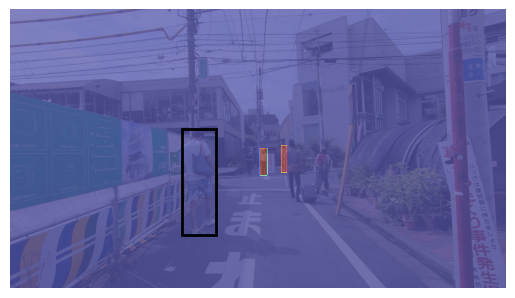

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


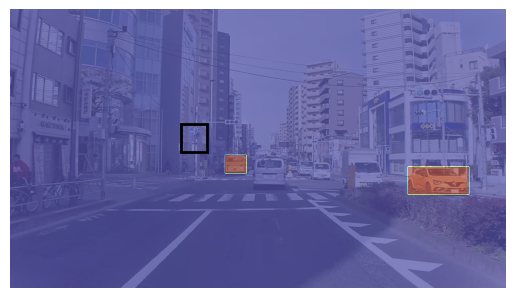

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


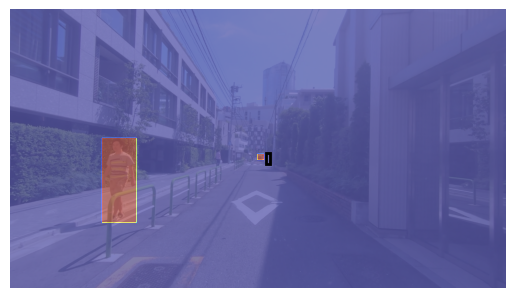

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


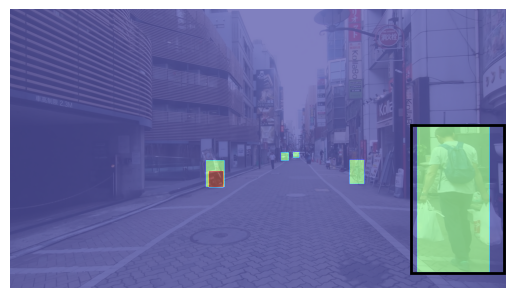

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


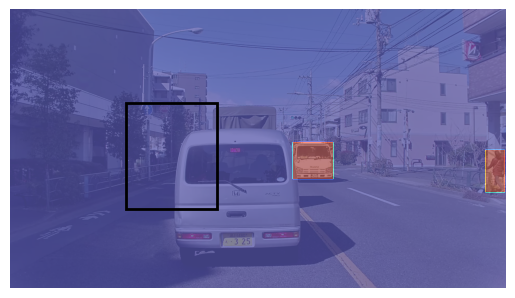

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


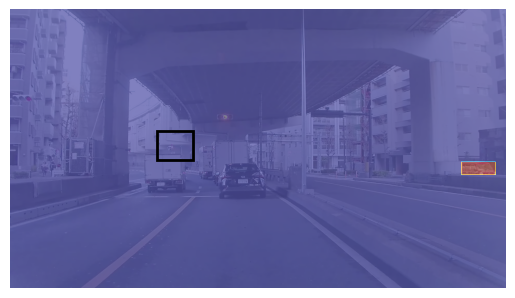

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


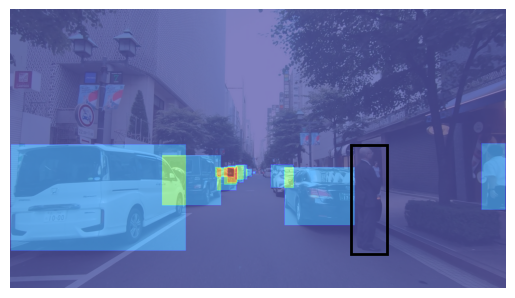

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


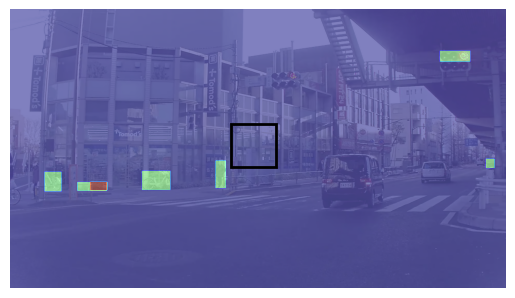

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


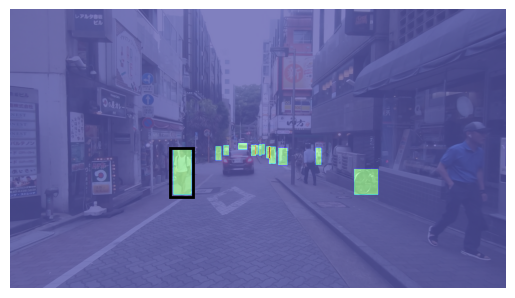

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


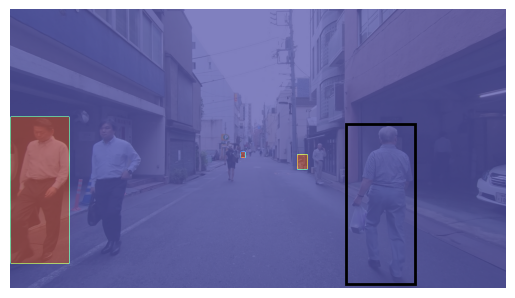

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


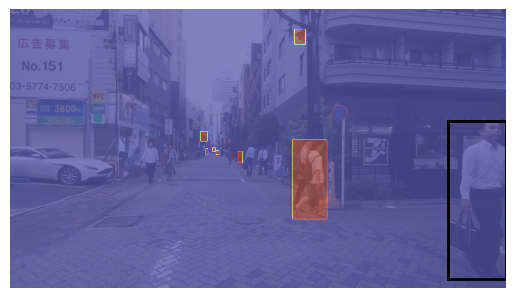

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


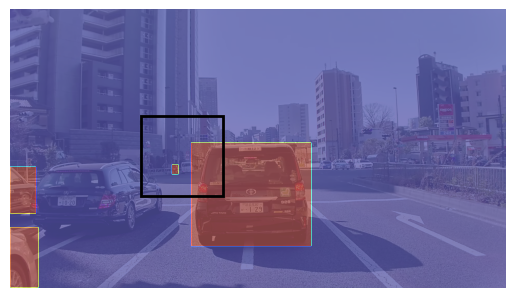

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


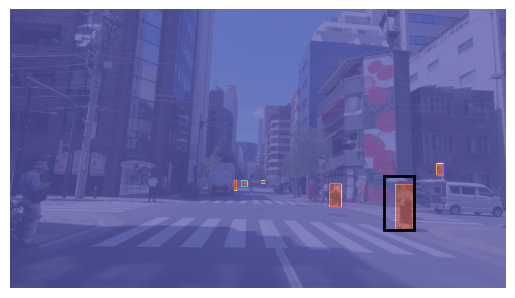

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


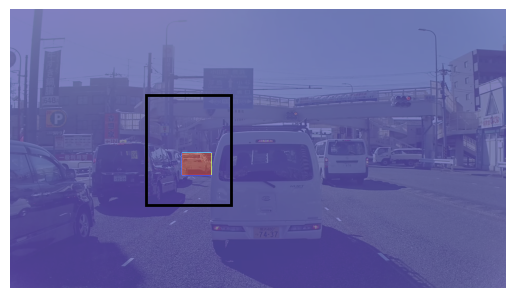

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


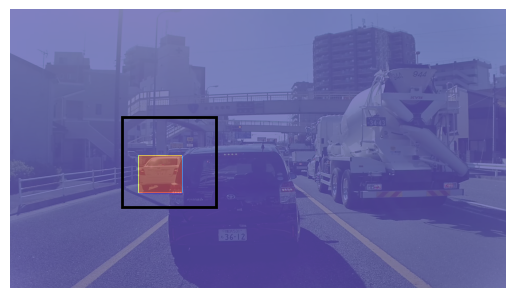

<ipython-input-5-b0d5d2a53e45>:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_batch[key] = torch.stack([torch.tensor(example[key]) for example in batch])


In [ ]:
import torch
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.patches import Rectangle
import requests
from io import BytesIO

def plot_heatmap_on_image(image_url, bbox_coords, attention_scores, ground_truth_bbox=None):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert("RGBA")
    img = img.resize((2704, 1520))
    img_np = np.array(img)

    heatmap = np.zeros((img_np.shape[0], img_np.shape[1]))

    for bbox, score in zip(bbox_coords, attention_scores):
        xmin, ymin, xmax, ymax = bbox.astype(int)
        heatmap[ymin:ymax, xmin:xmax] += score

    fig, ax = plt.subplots(1)
    ax.imshow(img_np, alpha=0.5)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)

    # Plot ground truth bounding box
    if ground_truth_bbox is not None:
        xmin, ymin, xmax, ymax = ground_truth_bbox[0] * 2704, ground_truth_bbox[1] * 1520, ground_truth_bbox[2] * 2704, ground_truth_bbox[3] * 1520
        rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

def filter_bboxes_and_scores(bbox_coords, attention_scores):
    # Filter out boxes that are all zeros or represent the whole image
    valid_indices = (bbox_coords.sum(dim=-1) != 0) & ((bbox_coords != torch.tensor([0, 0, 1, 1], device=bbox_coords.device)).all(dim=-1))
    filtered_bboxes = bbox_coords[valid_indices]
    filtered_scores = attention_scores[valid_indices]
    return filtered_bboxes, filtered_scores

def visualize_first_cluster(valid_dataloader, model, device, k=3, img_width=2704, img_height=1520):
    model.to(device)
    model.eval()

    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            if idx != 0:
                break  # Only process the first batch

            # Move the batch to the selected device
            object_features = batch["object_features"].to(device, torch.float32)
            bbox = batch["bbox"].to(device, torch.float32)
            image_urls = batch["s3_fileUrl"]
            target_bboxes = normalize_bboxes(batch["geometry"], img_width, img_height).cpu()

            # Forward pass
            _, all_bbox_coords, attention_weights = model(object_features, bbox)

            # Convert to CPU for clustering
            all_bbox_coords_cpu = all_bbox_coords.cpu().numpy()
            attention_weights_cpu = attention_weights.cpu().numpy()

            # Clustering for the first sample in the batch
            for i in range(all_bbox_coords_cpu.shape[0]):
                # Filter out invalid bounding boxes
                filtered_bboxes, filtered_scores = filter_bboxes_and_scores(all_bbox_coords[i], attention_weights[i])

                # Convert to numpy for clustering
                filtered_bboxes_np = filtered_bboxes.cpu().numpy()
                filtered_scores_np = filtered_scores.cpu().numpy()

                # Only perform clustering if there are valid bounding boxes left and enough samples
                if len(filtered_bboxes_np) >= k:
                    kmeans = KMeans(n_clusters=k, random_state=0).fit(filtered_scores_np.reshape(-1, 1))
                    cluster_labels = kmeans.labels_

                    # Find the bounding boxes in the first cluster
                    first_cluster_bboxes = filtered_bboxes_np[cluster_labels == 0]
                    first_cluster_scores = filtered_scores_np[cluster_labels == 0]

                    # Normalize the bounding boxes back to the image size
                    first_cluster_bboxes = first_cluster_bboxes * np.array([img_width, img_height, img_width, img_height])

                    # Visualize the bounding boxes on the image
                    plot_heatmap_on_image(image_urls[i], first_cluster_bboxes, first_cluster_scores, ground_truth_bbox=target_bboxes[i])

# Example usage:
visualize_first_cluster(valid_dataloader, attention_predictor_new, device)


**Train Blip2 with/without attention map**

In [ ]:
import torch
from tqdm import tqdm
from transformers import AutoTokenizer
import warnings

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# optimizer_attention = torch.optim.Adam(attention_predictor.parameters(), lr=1e-5)

# Choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)
# attention_predictor.to(device)

# Training loop
model.train()

# Criterion for bounding box regression
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor")

for epoch in range(5):
    # Training loop
    total_loss = 0
    num_batches = 0

    # Initialize the progress bar
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch + 1}/5")

    for idx, batch in progress_bar:
        # Move the batch to the selected device
        input_ids = batch["input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device, torch.float16)
        object_features = batch["object_features"].to(device, torch.float32)
        bbox = batch["bbox"].to(device)
        batch_bbox_coords_target = batch["geometry"].to(device)


        # Check attention predictor accuracy
        batch_bbox_coords_target = batch["geometry"].to(device)
        target_bboxes = normalize_bboxes(batch_bbox_coords_target, 2704, 1520).to(device)
        batch_bbox_coords_inter = bbox_to_corners(target_bboxes, 2704, 1520, device)
        batch_object_patch_indices = calculate_covered_patch_indices(batch_bbox_coords_inter, original_image_size=(2704, 1520))

        labels = input_ids.clone()

        # Forward pass
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels, batch_object_patch_indices=batch_object_patch_indices)
        loss = outputs.loss
        total_loss += loss.item()
        num_batches += 1

        # Backward pass and optimization
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Update the progress bar
        progress_bar.set_postfix({'loss': total_loss / num_batches})

    scheduler.step()

    # Print average loss for the epoch
    avg_loss = total_loss / num_batches
    print(f"Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")
    model.save_pretrained("blip2_frame_v4.3")
    model.push_to_hub("SeeonQwQ/blip2_frame_v4.3")


Epoch 1/5:   0%|          | 0/490 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Epoch 1/5: 100%|██████████| 490/490 [8:58:16<00:00, 65.91s/it, loss=0.591]


Average Loss for Epoch 1: 0.5914


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Epoch 2/5: 100%|██████████| 490/490 [8:58:54<00:00, 65.99s/it, loss=0.58]


Average Loss for Epoch 2: 0.5803


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Epoch 3/5:  62%|██████▏   | 303/490 [5:32:45<3:33:26, 68.49s/it, loss=0.572]

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from tqdm import tqdm
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

def filter_bboxes_and_scores(bbox_coords, attention_scores):
    valid_indices = (bbox_coords.sum(dim=-1) != 0) & ((bbox_coords != torch.tensor([0, 0, 1, 1], device=bbox_coords.device)).all(dim=-1))
    filtered_bboxes = bbox_coords[valid_indices]
    filtered_scores = attention_scores[valid_indices]
    return filtered_bboxes, filtered_scores

def validate(valid_dataloader, model1, model2, attention_predictor, processor, device, k=3, img_width=2704, img_height=1520):
    model1.to(device)
    model2.to(device)
    attention_predictor.to(device)

    model1.eval()
    model2.eval()
    attention_predictor.eval()

    total_samples = 0

    generated_texts = []

    with torch.no_grad():
        progress_bar = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader), desc="Validation")

        for idx, batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            pixel_values = batch["pixel_values"].to(device, torch.float16)
            file_names = batch["s3_fileUrl"]
            labels = input_ids.clone()

            batch_bbox_coords_target = batch["geometry"].to(device)
            target_bboxes = normalize_bboxes(batch_bbox_coords_target, img_width, img_height).to(device)
            batch_bbox_coords_inter = bbox_to_corners(target_bboxes, img_width, img_height, device)
            batch_object_patch_indices = calculate_covered_patch_indices(batch_bbox_coords_inter, original_image_size=(img_width, img_height))

            object_features = batch["object_features"].to(device, torch.float32)
            bbox = batch["bbox"].to(device, torch.float32)
            _, all_bbox_coords, attention_weights = attention_predictor(object_features, bbox)

            all_bbox_coords_cpu = all_bbox_coords.cpu().numpy()
            attention_weights_cpu = attention_weights.cpu().numpy()

            batch_first_cluster_patches = []

            for i in range(all_bbox_coords_cpu.shape[0]):
                filtered_bboxes, filtered_scores = filter_bboxes_and_scores(all_bbox_coords[i], attention_weights[i])
                filtered_bboxes_np = filtered_bboxes.cpu().numpy()
                filtered_scores_np = filtered_scores.cpu().numpy()

                if len(filtered_bboxes_np) <= k:
                    first_cluster_bboxes = filtered_bboxes_np
                else:
                    kmeans = KMeans(n_clusters=k, random_state=0).fit(filtered_scores_np.reshape(-1, 1))
                    cluster_labels = kmeans.labels_
                    first_cluster_bboxes = filtered_bboxes_np[cluster_labels == 0]

                first_cluster_bboxes_torch = torch.tensor(first_cluster_bboxes).to(device)
                cluster_patches = calculate_covered_patch_indices(bbox_to_corners(first_cluster_bboxes_torch, img_width, img_height, device), original_image_size=(img_width, img_height))

                # Merge patches for the current sample
                merged_patches = set()
                for patch in cluster_patches:
                    merged_patches.update(patch)

                batch_first_cluster_patches.append(merged_patches)


            old_generated_ids = model1.generate(pixel_values=pixel_values, max_length=50)
            old_generated_texts = [processor.decode(old_generated_ids[i], skip_special_tokens=True) for i in range(old_generated_ids.size(0))]

            new_generated_ids_one = model2.generate(pixel_values=pixel_values, max_length=50, batch_object_patch_indices=batch_object_patch_indices)
            new_generated_texts_one = [processor.decode(new_generated_ids_one[i], skip_special_tokens=True) for i in range(new_generated_ids_one.size(0))]

            new_generated_ids_more = model2.generate(pixel_values=pixel_values, max_length=50, batch_object_patch_indices=batch_first_cluster_patches)
            new_generated_texts_more = [processor.decode(new_generated_ids_more[i], skip_special_tokens=True) for i in range(new_generated_ids_more.size(0))]

            for j in range(len(file_names)):
                generated_texts.append({
                    "file_name": file_names[j],
                    "old_generated_text": old_generated_texts[j],
                    "new_generated_text_one_box": new_generated_texts_one[j],
                    "new_generated_text_more_boxes": new_generated_texts_more[j]
                })

            total_samples += len(file_names)

    generated_texts_df = pd.DataFrame(generated_texts)
    generated_texts_df.to_csv("generated_texts.csv", index=False)

    return generated_texts_df

# Example usage:
validate(valid_dataloader, model1, model2, attention_predictor_new, processor, device)


Validation:   0%|          | 0/55 [00:00<?, ?it/s]<ipython-input-9-b0d5d2a53e45>:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_batch[key] = torch.stack([torch.tensor(example[key]) for example in batch])
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the v

,file_name,old_generated_text,new_generated_text_one_box,new_generated_text_more_boxes
0,https://s3-us-west-2.amazonaws.com/hrius.scale...,A van is slowing in the lane due to traffic.,A van is stopped in the lane due to traffic co...,A hatchback is stopped in the lane due to traf...
1,https://s3-us-west-2.amazonaws.com/hrius.scale...,A van is driving away from a car.,A van is driving away from a car.,A van is driving away from a car.
2,https://s3-us-west-2.amazonaws.com/hrius.scale...,A van is driving away from a car.,A truck is driving away from a car.,A truck is driving away from a car.
3,https://s3-us-west-2.amazonaws.com/hrius.scale...,A pedestrian is walking on the road away from ...,A pedestrian is walking on the road away from ...,A pedestrian is walking on the road away from ...
4,https://s3-us-west-2.amazonaws.com/hrius.scale...,A truck is driving away from a car.,A traffic light is in front of the car.,A truck is driving away from a car.
...,...,...,...,...
867,https://s3-us-west-2.amazonaws.com/hrius.scale...,A pedestrian is walking on the road away from ...,A van is parked on the road.,A pedestrian is walking on the road away from ...
868,https://s3-us-west-2.amazonaws.com/hrius.scale...,A pedestrian is walking on the road away from ...,A pedestrian is walking on the road away from ...,A pedestrian is walking on the road away from ...
869,https://s3-us-west-2.amazonaws.com/hrius.scale...,A van is parked on the road.,A van is parked on the road.,A van is parked on the road.
870,https://s3-us-west-2.amazonaws.com/hrius.scale...,A hatchback is stopped in front of the car due...,A sedan is stopped in the lane due to traffic.,A hatchback is stopped in the lane due to traf...


Useless Code

In [ ]:
import torch

def normalize_bboxes(bboxes, img_width, img_height):
    """
    Normalize bounding box coordinates to be between 0 and 1.

    Parameters:
    - bboxes (list or array): List or array of bounding boxes, each specified by four coordinates.
    - img_width (int): Width of the image.
    - img_height (int): Height of the image.

    Returns:
    - Tensor: Normalized bounding boxes of shape (batch_size, 4).
    """
    # Print shape for debugging
    print(f"Original bboxes shape: {bboxes.shape}")

    if isinstance(bboxes, list):
        bboxes = torch.tensor(bboxes)
    elif isinstance(bboxes, np.ndarray):
        bboxes = torch.from_numpy(bboxes)

    # Assuming bboxes should be of shape (batch_size, 4)
    if bboxes.dim() == 2 and bboxes.size(1) == 4:
        x_min, y_min = bboxes[:, 0], bboxes[:, 1]
        x_max, y_max = bboxes[:, 2], bboxes[:, 3]
    elif bboxes.dim() == 3 and bboxes.size(2) == 2:
        # If the bboxes are in (batch_size, 2, 2) format
        x_min, y_min = bboxes[:, 0, 0], bboxes[:, 0, 1]
        x_max, y_max = bboxes[:, 1, 0], bboxes[:, 1, 1]
    else:
        raise ValueError(f"Unexpected bboxes shape: {bboxes.shape}")

    # Normalize coordinates
    x_min = x_min / img_width
    y_min = y_min / img_height
    x_max = x_max / img_width
    y_max = y_max / img_height

    # Stack to get the final tensor of shape (batch_size, 4)
    normalized_bboxes = torch.stack((x_min, y_min, x_max, y_max), dim=-1)

    return normalized_bboxes




In [ ]:
def bbox_iou(bbox1, bbox2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Bounding boxes are defined with the format [x_min, y_min, x_max, y_max].
    """
    x_min1, y_min1, x_max1, y_max1 = bbox1[:, 0], bbox1[:, 1], bbox1[:, 2], bbox1[:, 3]
    x_min2, y_min2, x_max2, y_max2 = bbox2[:, 0], bbox2[:, 1], bbox2[:, 2], bbox2[:, 3]

    # Calculate coordinates for the intersection rectangle
    inter_x_min = torch.max(x_min1, x_min2)
    inter_y_min = torch.max(y_min1, y_min2)
    inter_x_max = torch.min(x_max1, x_max2)
    inter_y_max = torch.min(y_max1, y_max2)

    # Calculate intersection area
    inter_area = torch.max(inter_x_max - inter_x_min, torch.zeros_like(inter_x_min)) * \
                 torch.max(inter_y_max - inter_y_min, torch.zeros_like(inter_y_min))

    # Calculate each rectangle's area
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # Calculate union area
    union_area = area1 + area2 - inter_area

    # Compute the IoU
    iou = inter_area / union_area
    return iou